# GAN + Generación de datos agrícolas sintéticos + Análisis

In [22]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Generación de datos agrícolas sintéticos base

Cultivo: Elección de uno de los cultivos disponibles.

Hectareas: Superficie de cultivo entre 1 y 10 hectareas.

Temperatura: Temperatura ambiental simulada con distribución normal centrada en 25°.

Lluvia: Precipitación con distribución exponencial.

Humedad: Humedad del suelo con distribución normal con media de 60%.

Fertilizante: Fertilizante en kg proporcional a las hectareas y un factor aleatorio.

factor_cultivo: Cada cultivo tiene un factor de productividad en kg/ha.

Clima_ajuste: Se penaliza la producción si las condiciones climaticas son desfavorables.
- Temperatura fuera de rango
- Humedad inadecuada
- Poca lluvia

Se agrega ruido a los datos.

In [23]:
cultivos = ["maíz", "trigo", "soja", "papa"]
dias = pd.date_range("2024-01-01", "2024-12-31")


def generar_datos_finca():
    registros = []
    for fecha in dias:
        cultivo = random.choice(cultivos)
        hectareas = round(np.random.uniform(1.0, 10.0), 2)
        temp = round(np.random.normal(25, 5), 1)
        lluvia = max(0, round(np.random.exponential(5), 1))
        humedad = round(np.random.normal(60, 15), 1)
        fertilizante = round(hectareas * np.random.uniform(2.0, 5.0), 1)

        factor_cultivo = {"maíz": 800, "trigo": 700, "soja": 600, "papa": 1000}
        base = hectareas * factor_cultivo[cultivo]

        clima_ajuste = 1.0
        if temp < 20 or temp > 32:
            clima_ajuste -= 0.15
        if humedad < 40 or humedad > 80:
            clima_ajuste -= 0.1
        if lluvia < 1.0:
            clima_ajuste -= 0.1

        produccion = round(base * clima_ajuste *
                           np.random.uniform(0.9, 1.1), 1)

        registros.append({
            "hectareas": hectareas,
            "temperatura": temp,
            "precipitacion": lluvia,
            "humedad_suelo": humedad,
            "fertilizante_kg": fertilizante,
            "produccion_kg": produccion,
        })

    return pd.DataFrame(registros)


# Generar datos y normalizar
df = generar_datos_finca()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values)
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

input_dim = data_tensor.shape[1]
latent_dim = 16

### Histograma de datos originales generados

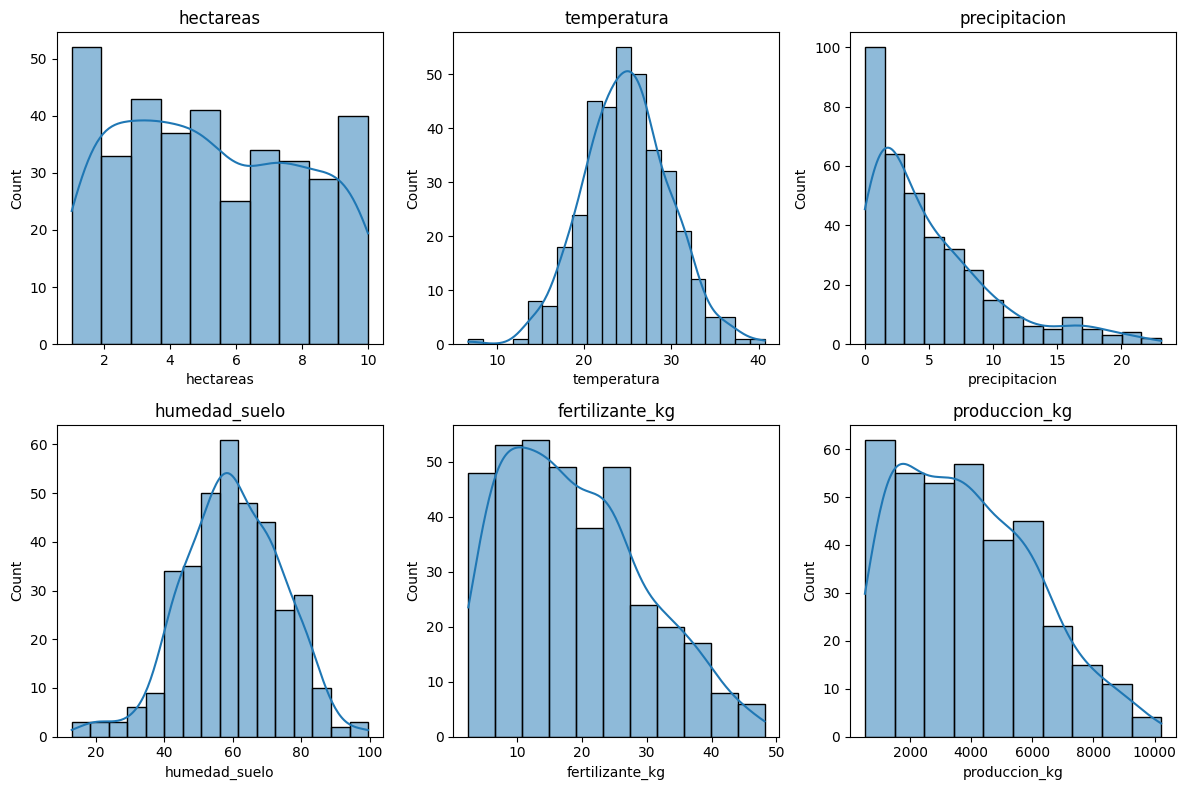

In [29]:
# Histogramas de los datos originales
def plot_histograms(df):
    plt.figure(figsize=(12, 8))
    for i, column in enumerate(df.columns):
        plt.subplot(2, 3, i + 1)
        sns.histplot(df[column], kde=True)
        plt.title(column)
    plt.tight_layout()
    plt.show()
    
plot_histograms(df)

### Definición de la red GAN

Define y configura una Red Generativa Antagónica (GAN) compuesta por dos redes neuronales: un generador y un discriminador. 

El generador toma vectores de ruido aleatorios y los transforma en datos sintéticos que imitan características de datos agrícolas reales.

El discriminador, por su parte, recibe como entrada tanto datos reales como generados y aprende a distinguir entre ambos, devolviendo una probabilidad de veracidad.

In [24]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

### Entrenamiento de la GAN

Epocas: 3000

Lote por paso: 64

1. En cada epoca se selecciona un lote aleatorio de datos del conjunto de entrenamiento para entrenar al discriminador.
2. Se calcula la perdida del discriminador con la salida de etiquetas (1 datos reales, 0 para falsos)

d_loss: perdida total del discriminador.

3. Se actualizan los pesos del discriminador con retropropragación y descenso del gradiente.
4. Se generar nuevos datos sintenticos para ahora entrenar al generador.
5. Se actualizan los pesos del discriminador.
6. Se monitoriea las perdidas del discriminador y generador cada 500 epocas.

Este enfoque competitivo entre ambas redes permite que, con el tiempo, el generador aprenda a producir datos sintéticos cada vez más realistas.



In [25]:
epochs = 3000
batch_size = 64

for epoch in range(epochs):
    idx = np.random.randint(0, data_tensor.shape[0], batch_size)
    real_batch = data_tensor[idx]

    z = torch.randn(batch_size, latent_dim)
    fake_batch = generator(z).detach()

    d_loss_real = criterion(discriminator(real_batch),
                            torch.ones(batch_size, 1))
    d_loss_fake = criterion(discriminator(fake_batch),
                            torch.zeros(batch_size, 1))
    d_loss = d_loss_real + d_loss_fake

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    z = torch.randn(batch_size, latent_dim)
    fake_batch = generator(z)
    g_loss = criterion(discriminator(fake_batch), torch.ones(batch_size, 1))

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 500 == 0:
        print(
            f"Epoch {epoch} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

Epoch 0 | D_loss: 1.3764 | G_loss: 0.6401
Epoch 500 | D_loss: 1.2927 | G_loss: 0.7427
Epoch 1000 | D_loss: 1.3307 | G_loss: 0.7516
Epoch 1500 | D_loss: 1.4137 | G_loss: 0.7153
Epoch 2000 | D_loss: 1.4236 | G_loss: 0.6838
Epoch 2500 | D_loss: 1.2354 | G_loss: 0.7590


### Generación y exportación de nuevos datos

Exportar el lote de datos sinteticos generados a un .csv

In [26]:
z = torch.randn(1000, latent_dim)
synthetic_data = generator(z).detach().numpy()
synthetic_data_original = scaler.inverse_transform(synthetic_data)

df_sintetico = pd.DataFrame(synthetic_data_original, columns=df.columns)
df_sintetico.to_csv("datos_agricolas_sinteticos_por_GAN.csv", index=False)
print("\nDatos sinteticos generados:")
print(df_sintetico.head())


Datos sinteticos generados:
   hectareas  temperatura  precipitacion  humedad_suelo  fertilizante_kg  \
0   9.792765    31.323801       0.902465      67.929718        12.760531   
1   1.385742    32.870201       1.765319      32.650459         3.258487   
2   1.424590    31.727512       1.702340      40.765991         3.412599   
3   8.979465    27.431870       2.583685      60.674652        13.803277   
4   8.987382    27.062197       3.411862      62.603546        22.015087   

   produccion_kg  
0    5305.852051  
1     597.894409  
2     589.441101  
3    5407.742188  
4    6151.156250  


### Análisis de los datos generados

Correlación de Pearson enter todas las variables, mostrando los coeficientes que indican qué tan linealmente relacionadas están.

Histograma: Observas distribución de las variables para detectar sesgos, valores extremos o simetría en las variables generadas.

Mapa de calor de correlación.

Graficos de dispersión: Se visualiza la relación entre fertilizante_kg y producción_kg, y entre hectáreas y producción_kg, permitiendo observar patrones, tendencias o comportamientos no lineales en los datos.



Matriz de correlación:
                 hectareas  temperatura  precipitacion  humedad_suelo  \
hectareas         1.000000    -0.449331      -0.075238       0.908598   
temperatura      -0.449331     1.000000      -0.450232      -0.456174   
precipitacion    -0.075238    -0.450232       1.000000       0.097814   
humedad_suelo     0.908598    -0.456174       0.097814       1.000000   
fertilizante_kg   0.873927    -0.630402       0.119860       0.816100   
produccion_kg     0.947026    -0.451650      -0.183818       0.827474   

                 fertilizante_kg  produccion_kg  
hectareas               0.873927       0.947026  
temperatura            -0.630402      -0.451650  
precipitacion           0.119860      -0.183818  
humedad_suelo           0.816100       0.827474  
fertilizante_kg         1.000000       0.902297  
produccion_kg           0.902297       1.000000  


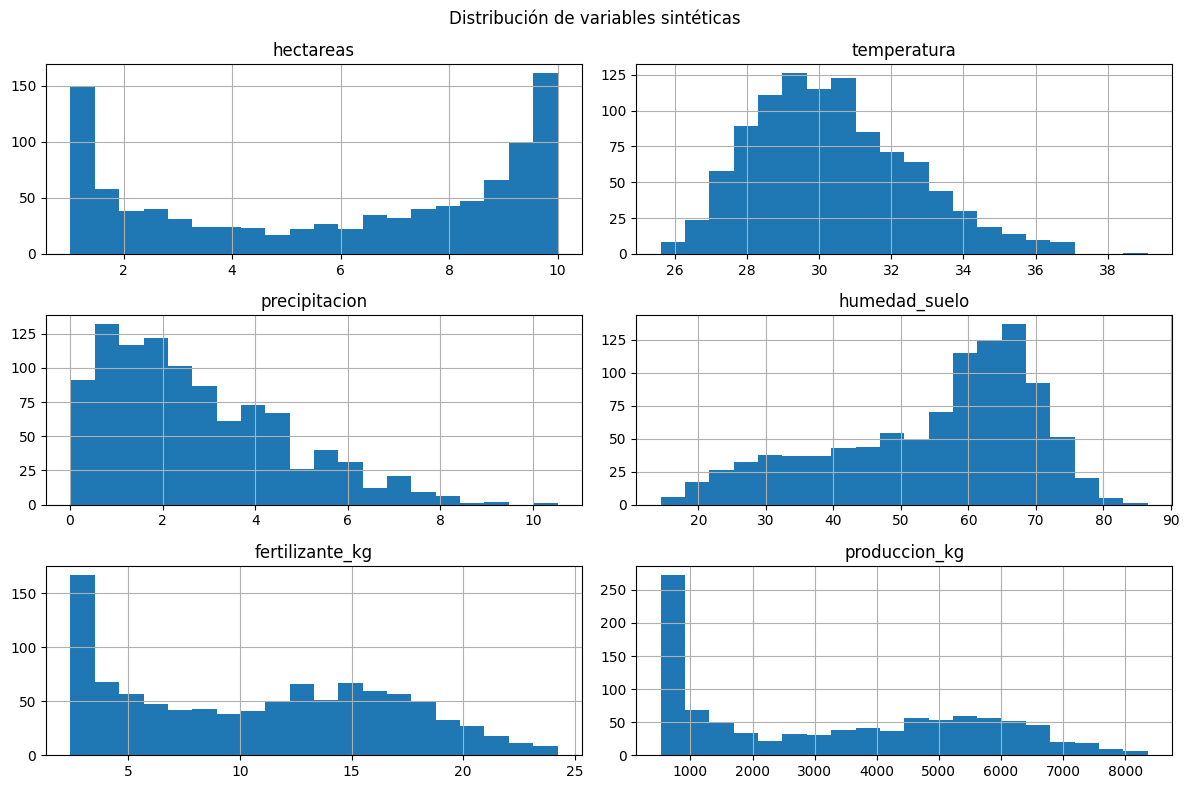

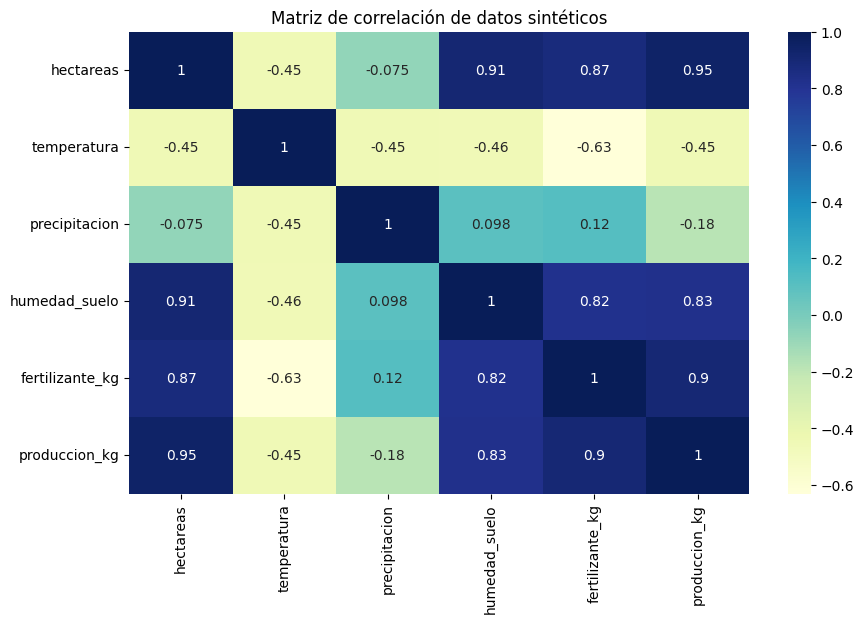

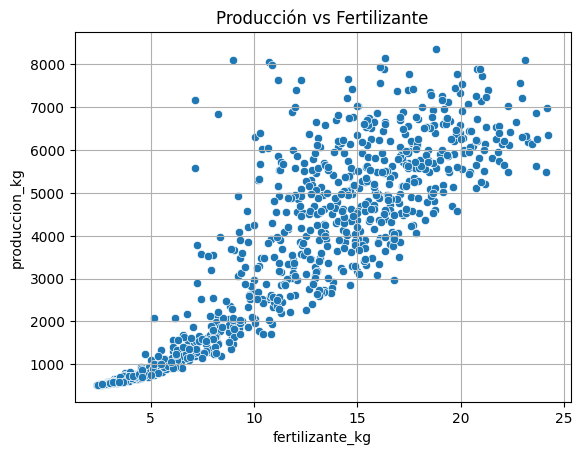

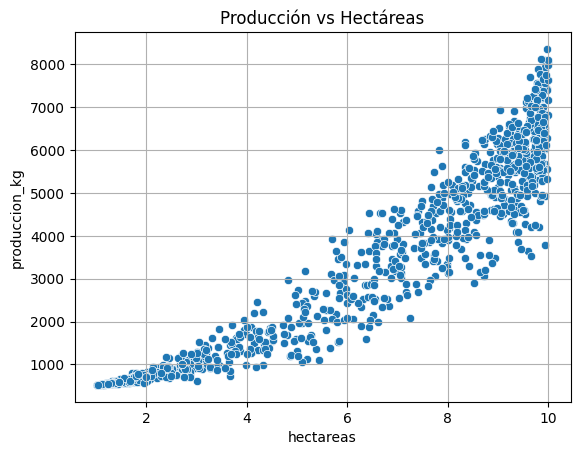

In [27]:
# Correlaciones
print("\nMatriz de correlación:")
print(df_sintetico.corr(numeric_only=True))

# Histogramas
df_sintetico.hist(bins=20, figsize=(12, 8))
plt.suptitle("Distribución de variables sintéticas")
plt.tight_layout()
plt.show()

# Mapa de calor de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df_sintetico.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.title("Matriz de correlación de datos sintéticos")
plt.show()

# Scatter plots
sns.scatterplot(x="fertilizante_kg", y="produccion_kg", data=df_sintetico)
plt.title("Producción vs Fertilizante")
plt.grid(True)
plt.show()

sns.scatterplot(x="hectareas", y="produccion_kg", data=df_sintetico)
plt.title("Producción vs Hectáreas")
plt.grid(True)
plt.show()

### Analisis de datos generados.

#### Datos
Hectáreas: Distribución bimodal (picos en ~1 ha y 10 ha). Refleja un patron real entre los tipos de explotaciones agricolas pequeñas y grandes. Sin embargo, la data incial que se genero para entrenar a la red se distribuyo de forma normal.

temperatura: Distribución normal centrada en 30 °C indica que la GAN generó una variable realista y continua.

precipitación: Distribución sesgada a la derecha. Razonable en climas áridos y en los datos iniciales tenian una distribución exponencial negativa.

humedad_suelo y fertilizante_kg: Muestran sesgos esperables; la GAN parece haber aprendido relaciones no lineales con la producción, lo cual es una buena señal de que capturó cierta complejidad.

producción_kg: La asimetría positiva sugiere que la GAN está generando datos con rango realista y dispersión lógica, pero habría que verificar que no esté sobreajustada a valores comunes y dejando fuera casos extremos.

#### Correlaciones

Correlaciones fuertes y positivas con la producción:
- Hectareas (0.95)
- Fertilizante (0.9)
- Humedad (0.83)

Correlacion negativa entre temperatura y la producción (-0.45)